<a href="https://colab.research.google.com/github/suuungwoo/TensorFlow-Core/blob/master/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Deep Convolutional Generative Adversarial Network](https://www.tensorflow.org/tutorials/generative/dcgan?hl=ja)

In [0]:
%tensorflow_version 2.x

import tensorflow as tf
tf.__version__

TensorFlow 2.x selected.


'2.0.0'

In [0]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

## データセットをロードする

In [0]:
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images.shape

(60000, 28, 28)

In [0]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# モデルを作成する

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((7,7,256)))
    assert model.output_shape == (None, 7, 7, 256)
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1,1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7,7,128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    
    return model

## Generator

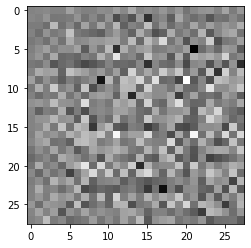

In [0]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0,:,:,0],cmap='gray')

## Discriminator

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))
    
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

In [0]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00186836]], shape=(1, 1), dtype=float32)


# loss, optimizerを定義する

In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## Discriminatorの損失

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss 

## Generatorの損失

In [0]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## checkpointを保存する

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

# 学習ループを定義する

In [0]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
def train(dataset, epochs) :
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(image_batch)
            
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch+1, seed)
        
        if (epoch+1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            
        print("Time for epoch {} is {} sec".format(epoch+1, time.time() - start))
        
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [0]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    
    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(predictions[i,:,:,0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        
    plt.savefig('drive/My Drive/Colab Notebooks/TensorFlow-Core/tutorial/dist/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


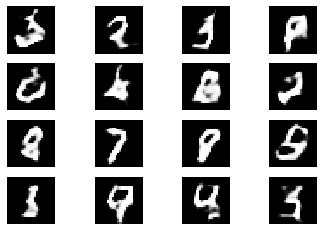

Time for epoch 38 is 26.405680179595947 sec


In [0]:
train(train_dataset, EPOCHS)